In [1]:
import numpy as np
import keras as k
import matplotlib.pyplot as plt
import h5py

In [2]:
matFilename='/Users/jacekdmochowski/PROJECTS/neuroedge_model_audit/data/Phase3A/subject_13/allDataForPy.mat'

In [3]:
arrays={}
f=h5py.File(matFilename,'a')

In [4]:
for k,v in f.items():
    arrays[k]=np.array(v)

In [5]:
eeg=np.array(arrays['allEEG'])

In [6]:
whos

Variable      Type       Data/Info
----------------------------------
arrays        dict       n=6
eeg           ndarray    103480152x20: 2069603040 elems, type `float64`, 16556824320 bytes (15789.818115234375 Mb)
f             File       <HDF5 file "allDataForPy.mat" (mode r+)>
h5py          module     <module 'h5py' from '/Use<...>ckages/h5py/__init__.py'>
k             str        allTransData
matFilename   str        /Users/jacekdmochowski/PR<...>bject_13/allDataForPy.mat
np            module     <module 'numpy' from '/Us<...>kages/numpy/__init__.py'>
plt           module     <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
v             Dataset    <HDF5 dataset "allTransDa<...>shape (1, 6), type "<u4">


In [7]:
eeg.shape

(103480152, 20)

here we chop up the EEG signal into smallish time-space arrays that will serve as examples in the VAE

In [8]:
fs=64 # sampling rate in Hz
windowSizeSecs=5 # how long each example will be, in seconds
windowShiftSecs=5 # this controls overlap
windowSizeSamples=windowSizeSecs*fs
windowShiftSamples=windowShiftSecs*fs

ok, now for real we are ready to chop it up
we need to find max_w such that w+winshift + winlen < T  # here python indexing actually helps

In [9]:
T=eeg.shape[0]
nWindows=np.floor_divide(T-windowSizeSamples,windowShiftSamples)
print("yo vanilla, you about to create " + str(nWindows) + " windows" )

yo vanilla, you about to create 323374 windows


In [11]:
D=eeg.shape[1]
eeg3d=np.empty([windowSizeSamples,D,nWindows])

In [12]:
eeg3d.shape

(320, 20, 323374)

In [13]:
for w in np.arange(nWindows): 
    eeg3d[:,:,w]=eeg[w*windowShiftSamples:w*windowShiftSamples+windowSizeSamples,:]

Text(0.5, 1.0, '310027')

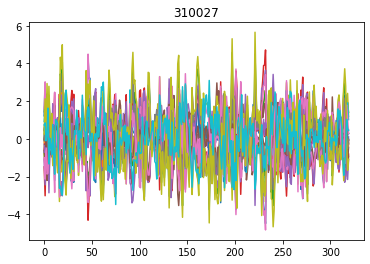

In [21]:
windx=np.random.randint(nWindows)
plt.plot(eeg3d[:,:,windx])
plt.title(str(windx))

Don't compand the EEG because it is not speech and distorting the spectrum may be a bad idea. Instead use a linear quantizer which they said was mucho problems for them. NB: do the normalization on each example individually, because the data here has been catenated over many days.

In [91]:
def quantize(xt,nSteps):
# linearly normalize to [-1,1] and quantize to nSteps steps
    #xt.ndims must be 1 or 2
    #xt=eeg3d[:,:,1000]
    #nSteps=256
    tmin=np.min(xt)
    tmax=np.max(xt)
    dy=(tmax-tmin)/nSteps
    xtn=(np.floor_divide(xt-tmin,dy))
    return xtn

In [92]:
qeeg3d=np.empty([windowSizeSamples,D,nWindows])
for w in np.arange(nWindows):
    qeeg3d[:,:,w]=quantize(eeg3d[:,:,w],256)

<ipython-input-91-577d323be68d>:10: RuntimeWarning: invalid value encountered in floor_divide
  xtn=(np.floor_divide(xt-tmin,dy))


Text(0.5, 1.0, '286295')

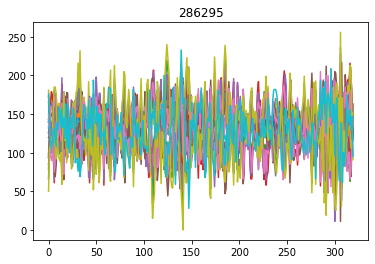

In [96]:
windx=np.random.randint(nWindows)
plt.plot(qeeg3d[:,:,windx])
plt.title(str(windx))